In [1]:
from config import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  24649


In [ ]:
model_WPINN = WPINN(input_size = len_collocation, 
                    family_size = len(family),
                    num_hidden_layers1 = 4, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons1 = 100,
                    hidden_neurons2 = 100).to(device)

optimizer1 = optim.Adam(model_WPINN.parameters(), lr=1e-5)#, weight_decay=1e-4)

c, b = model_WPINN(x_collocation, y_collocation)
len(c[0])

24649

In [3]:
# model_WPINN.load_state_dict(torch.load('model_parameters copy.pth'))

In [5]:
x_interior = x_collocation.clone()
y_interior = y_collocation.clone()

def wpinn_loss(model):   
    global c, b
    c, b = model(x_interior, y_interior)


    u = torch.mv(Wfamily, c[0]) + b[0]
    u_x = torch.mv(DWx, c[0])
    u_y = torch.mv(DWy, c[0])
    u_xx = torch.mv(DW2x, c[0])
    u_yy = torch.mv(DW2y, c[0])

    v = torch.mv(Wfamily, c[1]) + b[1]
    v_x = torch.mv(DWx, c[1])
    v_y = torch.mv(DWy, c[1])
    v_xx = torch.mv(DW2x, c[1])
    v_yy = torch.mv(DW2y, c[1])

    p_x = torch.mv(DWx, c[2])
    p_y = torch.mv(DWy, c[2])

    u_pred_bc_x_left = torch.mv(Wbc_x_left, c[0]) + b[0]
    u_pred_bc_x_right = torch.mv(Wbc_x_right, c[0]) + b[0]
    u_pred_bc_y_lower = torch.mv(Wbc_y_lower, c[0]) + b[0]
    u_pred_bc_y_upper = torch.mv(Wbc_y_upper, c[0]) + b[0]

    v_pred_bc_x_left = torch.mv(Wbc_x_left, c[1]) + b[1]
    v_pred_bc_x_right = torch.mv(Wbc_x_right, c[1]) + b[1]
    v_pred_bc_y_lower = torch.mv(Wbc_y_lower, c[1]) + b[1]
    v_pred_bc_y_upper = torch.mv(Wbc_y_upper, c[1]) + b[1]

    
    pde_loss = torch.mean((u_x + v_y) ** 2) +\
               torch.mean((u*u_x + v*u_y + p_x - (u_xx + u_yy)/Re)**2) +\
               torch.mean((u*v_x + v*v_y + p_y - (v_xx + v_yy)/Re)**2)

    bc_loss = torch.mean(u_pred_bc_x_left** 2) + torch.mean(u_pred_bc_x_right** 2) + torch.mean(u_pred_bc_y_lower** 2) + torch.mean((u_pred_bc_y_upper - 1)** 2) +\
              torch.mean(v_pred_bc_x_left** 2) + torch.mean(v_pred_bc_x_right** 2) + torch.mean(v_pred_bc_y_lower** 2) + torch.mean(v_pred_bc_y_upper**2)
    
    data_loss = (torch.mv(Wzero,c[2])+b[2])**2
    
    total_loss = pde_loss + bc_loss + data_loss
    
    return total_loss, pde_loss, bc_loss, data_loss

def train_wpinn(model, optimizer, num_prints):
    # Training loop
    pde_losses = []
    bc_losses = []
    for epoch in tqdm(range(num_epochs)):

        torch.cuda.empty_cache()
        
        optimizer.zero_grad()

        total_loss, pde_loss, bc_loss, data_loss = wpinn_loss(model)
        
        total_loss.backward()
        optimizer.step()
    
        
        if epoch % ((num_epochs-1)/num_prints) == 0:

            with torch.no_grad():
                u_pred = torch.mv(WTest, c[0].cpu()) + b[0].cpu()
                v_pred = torch.mv(WTest, c[1].cpu()) + b[1].cpu()
                vel_pred = ((u_pred**2 + v_pred**2)**0.5).reshape(n_test, n_test)


            vel_errL2 = (torch.sum(torch.abs(vel_ref-vel_pred)**2))**0.5 / (torch.sum(torch.abs(vel_ref)**2))**0.5
            vel_errMax = torch.max(torch.abs(vel_ref-vel_pred))
            
            print(f'Epoch [{epoch}/{num_epochs-1}], '
                  f'Total Loss: {total_loss.item():.6f}\t '
                  f'PDE Loss: {pde_loss.item():.6f}\t '
                  f'Data Loss: {data_loss.item():.6f}\t '
                  f'BC Loss: {bc_loss.item():.6f}, \n'
                  f'\t\t  vel:  RelativeL2: {vel_errL2}\t '
                  f'Max: {vel_errMax} \n')
            
        torch.cuda.empty_cache()
    
    return [pde_losses, bc_losses]

In [7]:
torch.cuda.empty_cache()

num_epochs = 10**4+1
l = train_wpinn(model_WPINN, optimizer1, num_prints=10)

  0%|          | 2/10001 [00:00<27:08,  6.14it/s]

Epoch [0/10000], Total Loss: 0.620552	 PDE Loss: 0.216426	 Data Loss: 0.056886	 BC Loss: 0.347241, 
		  vel:  RelativeL2: 0.5128730527969485	 Max: 0.5719159245491028 



 10%|█         | 1002/10001 [02:24<22:49,  6.57it/s]

Epoch [1000/10000], Total Loss: 0.014725	 PDE Loss: 0.001052	 Data Loss: 0.000000	 BC Loss: 0.013673, 
		  vel:  RelativeL2: 0.06457895806806976	 Max: 0.43942731618881226 



 20%|██        | 2002/10001 [04:48<20:31,  6.49it/s]

Epoch [2000/10000], Total Loss: 0.010562	 PDE Loss: 0.000705	 Data Loss: 0.000000	 BC Loss: 0.009857, 
		  vel:  RelativeL2: 0.03328626141460279	 Max: 0.3558256924152374 



 30%|███       | 3002/10001 [07:12<17:48,  6.55it/s]

Epoch [3000/10000], Total Loss: 0.009850	 PDE Loss: 0.001054	 Data Loss: 0.000001	 BC Loss: 0.008796, 
		  vel:  RelativeL2: 0.03517530363409488	 Max: 0.326057106256485 



 40%|████      | 4002/10001 [09:36<15:40,  6.38it/s]

Epoch [4000/10000], Total Loss: 0.008570	 PDE Loss: 0.000537	 Data Loss: 0.000000	 BC Loss: 0.008033, 
		  vel:  RelativeL2: 0.02664937065567521	 Max: 0.2981340289115906 



 50%|█████     | 5002/10001 [12:00<12:44,  6.54it/s]

Epoch [5000/10000], Total Loss: 0.009132	 PDE Loss: 0.001458	 Data Loss: 0.000003	 BC Loss: 0.007671, 
		  vel:  RelativeL2: 0.03091567375995064	 Max: 0.29268476366996765 



 60%|██████    | 6002/10001 [14:25<10:16,  6.49it/s]

Epoch [6000/10000], Total Loss: 0.007811	 PDE Loss: 0.000529	 Data Loss: 0.000000	 BC Loss: 0.007283, 
		  vel:  RelativeL2: 0.024669837683187885	 Max: 0.28056442737579346 



 70%|███████   | 7002/10001 [16:49<07:38,  6.55it/s]

Epoch [7000/10000], Total Loss: 0.008022	 PDE Loss: 0.000988	 Data Loss: 0.000009	 BC Loss: 0.007025, 
		  vel:  RelativeL2: 0.023659837149372826	 Max: 0.282087504863739 



 80%|████████  | 8002/10001 [19:13<05:06,  6.52it/s]

Epoch [8000/10000], Total Loss: 0.007767	 PDE Loss: 0.000858	 Data Loss: 0.000000	 BC Loss: 0.006909, 
		  vel:  RelativeL2: 0.02557471634646273	 Max: 0.2800273299217224 



 90%|█████████ | 9002/10001 [21:36<02:32,  6.54it/s]

Epoch [9000/10000], Total Loss: 0.008760	 PDE Loss: 0.001908	 Data Loss: 0.000013	 BC Loss: 0.006839, 
		  vel:  RelativeL2: 0.029901686149928386	 Max: 0.2858617901802063 



100%|██████████| 10001/10001 [24:00<00:00,  6.94it/s]

Epoch [10000/10000], Total Loss: 0.007218	 PDE Loss: 0.000646	 Data Loss: 0.000000	 BC Loss: 0.006572, 
		  vel:  RelativeL2: 0.023395141063364266	 Max: 0.2856466770172119 



In [13]:
trained_c = c
trained_b = b

name = ['0_u','1_v','2_p']
for i in range(3):
    file_name = "coeff_"+name[i]+".csv"
    np.savetxt(file_name, c[i].detach().cpu(), delimiter=",")

biases_save = [bias.detach().cpu() for bias in b]
file_name = "biases.csv"
np.savetxt(file_name, biases_save, delimiter=",")


file_name = "vel_pred_100.csv"
np.savetxt(file_name, vel_pred, delimiter=",")

torch.save(model_WPINN.state_dict(), 'model_parameters.pth')


RelativeL2: 0.021448821644494954 	 Max: 0.28246593475341797


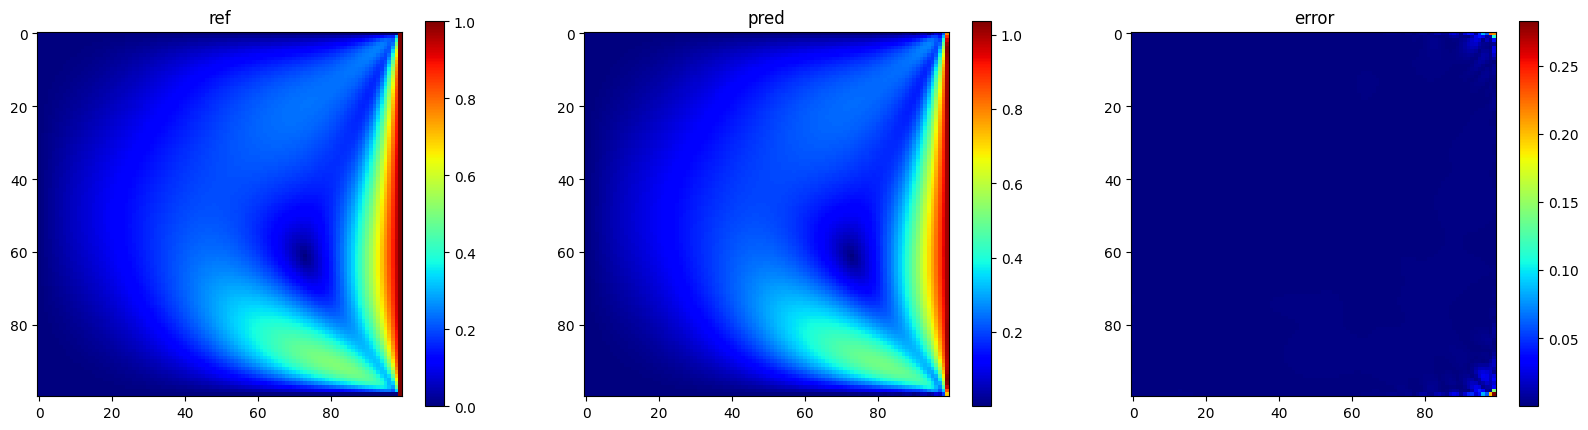

In [12]:
with torch.no_grad():
    u_pred = torch.mv(WTest, c[0].cpu()) + b[0].cpu()
    v_pred = torch.mv(WTest, c[1].cpu()) + b[1].cpu()
    vel_pred = ((u_pred**2 + v_pred**2)**0.5).reshape(n_test, n_test).cpu()


vel_errL2 = (torch.sum(torch.abs(vel_ref-vel_pred)**2))**0.5 / (torch.sum(torch.abs(vel_ref)**2))**0.5
vel_errMax = torch.max(torch.abs(vel_ref-vel_pred))
            
print(f'RelativeL2: {vel_errL2} \t Max: {vel_errMax}')


fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(vel_ref, cmap='jet')
plt.colorbar(cmap='jet')
plt.title('ref')

plt.subplot(1,3,2)
plt.imshow(vel_pred, cmap='jet')
plt.colorbar(cmap='jet')
plt.title('pred')

plt.subplot(1,3,3)
plt.imshow(abs(vel_pred-vel_ref), cmap='jet')
plt.colorbar(cmap='jet')
plt.title('error')
plt.savefig('Re100.jpg')
plt.show()

torch.cuda.empty_cache()

In [15]:
cord1_ghia = torch.linspace(0,1,500)
cord2_ghia = torch.tensor([0.5]*len(cord1_ghia))

jx = family[:, 0].cpu()
jy = family[:, 1].cpu() 
kx = family[:, 2].cpu() 
ky = family[:, 3].cpu()

Wval_u = gaussian(cord2_ghia, cord1_ghia, jx, jy, kx, ky).T
Wval_v = gaussian(cord1_ghia, cord2_ghia, jx, jy, kx, ky).T


u_pred_ghia = (torch.mv(Wval_u, c[0].cpu()) + b[0].cpu()).detach().numpy()
v_pred_ghia = (torch.mv(Wval_v, c[1].cpu()) + b[1].cpu()).detach().numpy()

np.savetxt("u_pred_ghia_100.csv", u_pred_ghia)
np.savetxt("v_pred_ghia_100.csv", v_pred_ghia)
